# 1. Vector Indexing with Langchain and ChromaDB

In [ ]:
# !pip install langchain
# !pip install chromadb
# !pip install sentence_transformers

# for langchain, you need to update the embedding folder with newst files from github
# (https://github.com/hwchase17/langchain/tree/0cf934ce7d8150dddf4a2514d6e7729a16d55b0f/langchain/embeddings)

In [ ]:
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma
import pandas as pd

In [ ]:
# load demo surveys
test_name = '/content/drive/MyDrive/OPPOS_RA/tables/Signifi_KB.csv'
survey_name = '/content/drive/MyDrive/OPPOS_RA/tables/Signifi_validation.csv'

survey_raw = pd.read_csv(survey_name)
test_raw = pd.read_csv(test_name)

In [ ]:
survey = survey_raw.copy()

# combine the question and answer into one string with a line break
survey['combined'] = survey['question'] + '\n' + survey['answer']

In [ ]:
# use the pre-trained SBERT embedding model for embedding (https://www.sbert.net/docs/pretrained_models.html)
embeddings = embeddings = SentenceTransformerEmbeddings(model="all-mpnet-base-v2")

# set a persist directory to store the embeddings on disk
persist_directory = '/content/drive/MyDrive/OPPOS_RA/chromaDB'

## Now we create embeddings for each survey entry and insert into the Chroma vector database. The persist_directory argument tells ChromaDB where to store the database when it’s persisted. Note that if you repeat this, you will get repeated entries in the vector database

In [ ]:
texts = list(survey['combined'])

# generate a vector DB with survey entries and their SBERT embeddings
surveysearch = Chroma.from_texts(texts=texts, embedding=embeddings, persist_directory=persist_directory)

In [ ]:
# load the embeddings from disk

surveysearch = None
surveysearch = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

In [ ]:
query = "Who from your company, the hosting provider, and anyone in your supply chain, will have access to Motorola Solutions data?"
query_results = surveysearch.similarity_search(query)

In [ ]:
print(query_results[0].page_content)

Who from your company, the hosting provider, and anyone in your supply chain, will have access to Motorola Solutions data?
Signifi customer service will have explicit access to data for business reasons. Signifi IT will have implicit access to data by having access to the database files and VM (but not to sensitive fields that are encrypted in the database).


# 2. Context Constructing

In [ ]:
def find_context(query: str,
                 vector_db: Chroma) -> str:

  """
  Given a query and a target Chroma DB, construct a context string by doing a
  similarity search of the query among the survey entires in the target DB.
  The survey entries will be ordered in a numbered list to help LLM
  understand the separation of entries.
  """
  query_results = vector_db.similarity_search(query, k=5)
  context = ''
  i = 1
  
  for result in query_results:
    content = f'{i}. ' + result.page_content + '\n'
    context += content
    i += 1

  return context

In [ ]:
print(find_context(query, surveysearch))

1. Who from your company, the hosting provider, and anyone in your supply chain, will have access to Motorola Solutions data?
Signifi customer service will have explicit access to data for business reasons. Signifi IT will have implicit access to data by having access to the database files and VM (but not to sensitive fields that are encrypted in the database).
2. Do you allow your personnel to store Motorola Solutions data on their personal devices?
No
3. What Hosting Providers will store or process Motorola Solutions data?
For multi-tenant:
Primary Data Center: OVH Montreal, QC, Canada
DR Data Center: Signifi office, Mississauga, ON, Canada
4. Do you store Motorola Solutions data on your enterprise network or assets?
Yes
5. Do you encrypt Motorola Solutions data at rest (application, file system, or database)? (This is not laptop encryption.)
Yes
On the multi-tenant server, data at rest is stored on an Ubuntu encrypted partition. Sensitive data (e.g. employee badge number) can be has

In [ ]:
import time

times_list = []

for i in range(100):
  start = time.time()
  find_context(query, surveysearch)
  end = time.time()
  times_list.append(end - start)

print(sum(times_list) / len(times_list))

0.2060312032699585


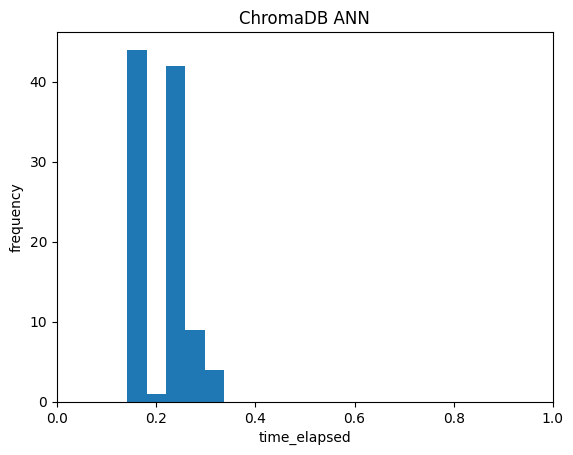

In [ ]:
import matplotlib.pyplot as plt

plt.hist(times_list, bins=5)
plt.xlim([0, 1])
plt.title('ChromaDB ANN')
plt.xlabel('time_elapsed')
plt.ylabel('frequency')
plt.show()


# 3. Question Answering with LLM
currently using GPT for lack of locally hosted alternatives

In [ ]:
#!pip install openai

In [ ]:
import openai

SEP = '=================='

# setting openai key
OPENAI_API = open('/content/drive/MyDrive/OPPOS_RA/OPENAI_API.txt', "r").read()
openai.api_key = OPENAI_API

COMPLETIONS_MODEL = "gpt-3.5-turbo"

In [ ]:
SYSTEM_MSG = "You are filling out a survey using the given context, "

GUIDE = "Answer the question as truthfully as possible and keep the answer short."\
        "Do not mention context or original answer."\
        "And if you are unsure of the answer, say only 'N/A' without giving any reason.\n\n"

def gpt_response(question: str, context: str='') -> str:
    complete_prompt= GUIDE + 'Context:\n' +\
                      context + 'Question:\n' + question

    return openai.ChatCompletion.create(
        temperature=0,
        messages=[
            {"role": "system", "content": SYSTEM_MSG},
            {"role": "user", "content": complete_prompt}
            ],
        max_tokens=1000,
        model=COMPLETIONS_MODEL
        )["choices"][0]["message"]['content'].strip(" \n")

In [ ]:
def fill_survey(question_df: pd.DataFrame, 
                question_col: str, 
                vector_db: Chroma) -> pd.DataFrame:
    
    result_df = question_df.copy()
    
    # find the context for each question
    result_df['context'] = result_df.apply(lambda x: find_context(x[question_col], vector_db), axis=1)
    
    # answer each question with the given context
    result_df['answer'] = result_df.apply(lambda x: gpt_response(x[question_col], x['context']), axis=1)

    return result_df

In [ ]:
# use GPT to fill the given unanswered survey
test = test_raw[['question']].copy()

start = time.time()
result_response = fill_survey(test, 'question', surveysearch)
end = time.time()


In [ ]:
end - start

111.29731893539429

In [ ]:
result_response

,question,context,answer
0,Company/Business name,1. Company name\nSignifi Solutions Inc\n2. Res...,Signifi Solutions Inc.
1,How long has the company been in business?,1. Company name\nSignifi Solutions Inc\n2. Do ...,N/A
2,Are there any material claims or judgments aga...,1. Is a disciplinary process in place for empl...,N/A
3,Has your company suffered a data loss or secur...,1. Do you participate in any industry cyber in...,N/A
4,Have any of your third party vendors suffered ...,"1. Do you ensure that your 3rd party partners,...",N/A
...,...,...,...
112,Do you have a vulnerability management program...,1. Do you carry out vulnerability scans as par...,Yes.
113,"Vulnerability assessments, scans or penetratio...",1. Are internet-facing and internal network sy...,Internet-facing and internal network systems.
114,"Are vulnerability assessements, scans or penet...",1. Do you carry out vulnerability scans as par...,Trained and experienced personnel.
115,Are vulnerability assessments or scans on inte...,1. How often is vulnerability scanning perform...,Yes.


In [ ]:
result_response.to_csv('/content/drive/MyDrive/OPPOS_RA/output_qa_chroma.csv', index=False)

## Run 1

Time: 106s

Response rate: 67 / 116

Accuracy:      58 / 67

## Run 2

Time: 111s

Response rate: 84 / 117

Accuracy: 67 / 84